In [1]:
pip install librosa pandas scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


###### 

MSE: 1.1787
MAE: 0.9485
Pearson Correlation: 0.3688


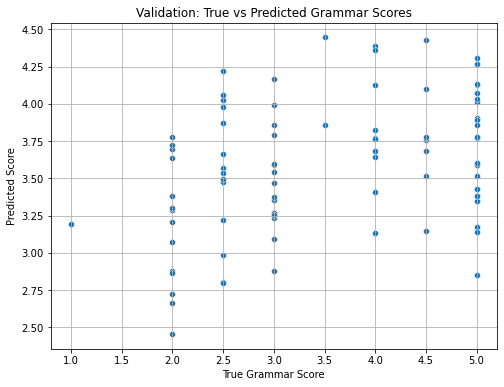

✅ submission.csv has been saved successfully!


In [4]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load the CSVs ===
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Rename columns for consistency
train_df.columns = ["file_name", "label"]
test_df.columns = ["file_name"]

# === Step 2: Set Audio Folder Paths ===
train_audio_path = "audios_train"
test_audio_path = "audios_test"

# === Step 3: Feature Extraction Function (MFCC) ===
def extract_features(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_scaled = np.mean(mfcc.T, axis=0)
        return mfcc_scaled
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc)

# === Step 4: Extract Features from Training Set ===
X = []
y = []

for _, row in train_df.iterrows():
    fname = row["file_name"]
    label = row["label"]
    fpath = os.path.join(train_audio_path, fname)

    feat = extract_features(fpath)
    X.append(feat)
    y.append(label)

X = np.array(X)
y = np.array(y)

# === Step 5: Split for Validation ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 6: Train a Model ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === Step 7: Evaluate ===
y_pred = model.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
pearson_corr, _ = pearsonr(y_val, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

# === Step 8: Plot True vs Predicted ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Score")
plt.title("Validation: True vs Predicted Grammar Scores")
plt.grid(True)
plt.show()

# === Step 9: Extract Features from Test Set ===
X_test = []

for fname in test_df["file_name"]:
    fpath = os.path.join(test_audio_path, fname)
    feat = extract_features(fpath)
    X_test.append(feat)

X_test = np.array(X_test)

# === Step 10: Predict on Test Set ===
test_preds = model.predict(X_test)

# === Step 11: Save Predictions ===
submission_df = pd.DataFrame({
    "file_name": test_df["file_name"],
    "label": test_preds
})

submission_df.to_csv("submission.csv", index=False)
print("✅ submission.csv has been saved successfully!")
